In [1]:
import sys
import numpy
import warnings
from sklearn.decomposition import FastICA
warnings.filterwarnings("ignore")
sys.path.append("../")
from lib.metadata import MetadataListTuep
from lib.signals import EegProcessorTuep
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.stats import StatisticalTests
from lib.bss import IWasobi, EogDenoiser, CanonicalCorrelation, EmgDenoiser
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

/var/tmp/venv-project-1/lib/python3.11/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### * Scales the EEG signal
### * Select a subset of the channels

{'full_file': '/mnt/c/Users/tobit/Downloads/eeg_datasets/tuep/aaaaaebo/s001_2006/02_tcp_le/aaaaaebo_s001_t000.edf', 'seizures': [(0.0, 0.0, 'bckg')]}
Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/tuep/aaaaaebo/s001_2006/02_tcp_le/aaaaaebo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2025-03-10 23:45:53,040 - root - INFO - Recording contains channels = ['EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE', 'EEG C4-LE', 'EEG A1-LE', 'EEG A2-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE', 'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE', 'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE', 'EEG OZ-LE', 'EEG PG1-LE', 'EEG PG2-LE', 'EEG EKG-LE', 'EEG 26-LE', 'EEG 27-LE', 'EEG 28-LE', 'EEG 29-LE', 'EEG 30-LE', 'EEG 31-LE', 'EEG 32-LE', 'PHOTIC PH', 'DC1-DC', 'DC2-DC', 'DC3-DC', 'DC4-DC', 'DC5-DC', 'DC6-DC', 'DC7-DC', 'DC8-DC']


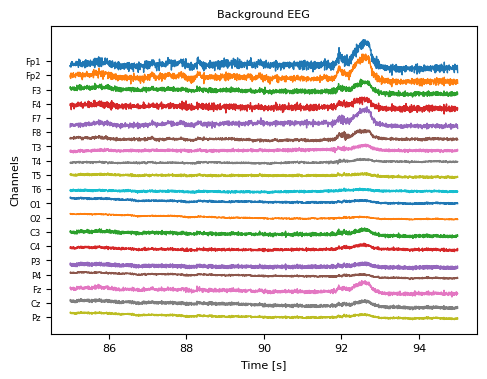

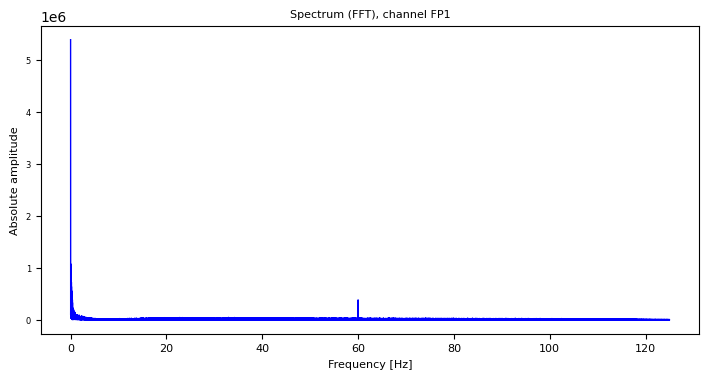

In [8]:
PATIENT = "aaaaaebo"
FILENAME = "aaaaaebo_s001_t000"
PERIOD = [85, 95]

###########################################################
metadata = MetadataListTuep()
current_metadata = metadata.get(PATIENT, FILENAME)
print(current_metadata)

###########################################################
processor = EegProcessorTuep(current_metadata["full_file"])
processor.scale()
processor.select_channels()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1")

In [9]:
print(processor._data.shape)
print(processor.sampling_frequency)
print(current_metadata)

(19, 318750)
250.0
{'full_file': '/mnt/c/Users/tobit/Downloads/eeg_datasets/tuep/aaaaaebo/s001_2006/02_tcp_le/aaaaaebo_s001_t000.edf', 'seizures': [(0.0, 0.0, 'bckg')]}


### * Re-referencing to average reference

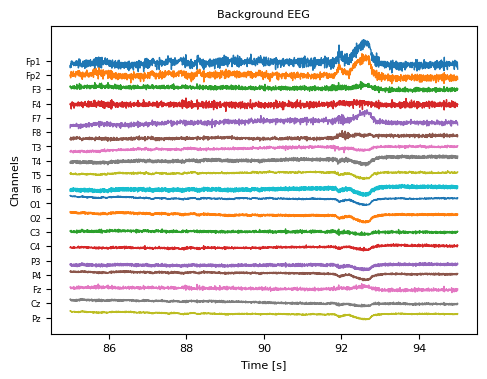

In [4]:
###########################################################
processor.rereference_to_average()

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

### * Resample the EEG to 256Hz

2025-03-10 23:46:03,233 - root - INFO - Selected frequency is = 250
2025-03-10 23:46:03,236 - root - INFO - Dowsampling factor is = 1


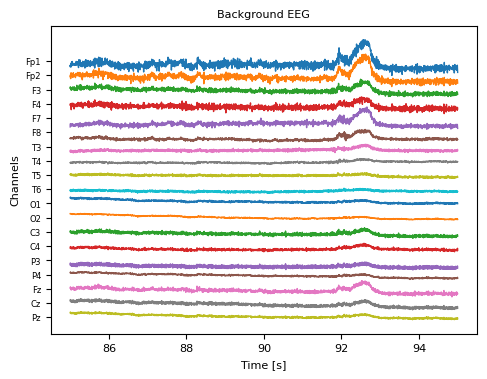

In [10]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)


### * Remove the drift noise, high frequency oscillations, power line noise

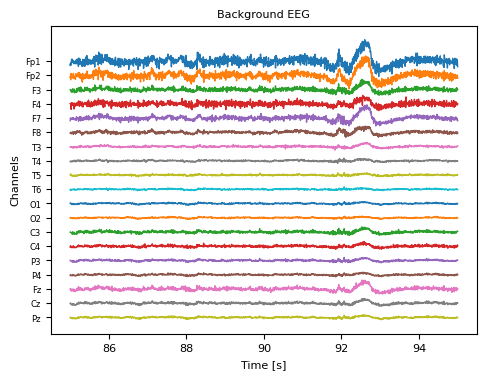

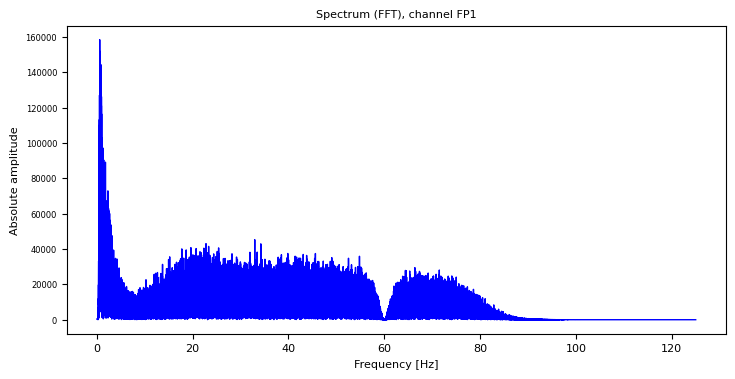

In [11]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1")

### * Separated sources using iWASOBI

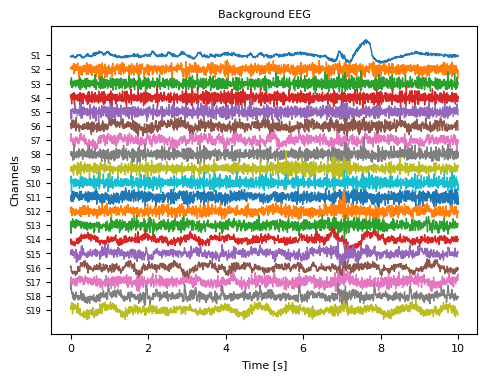

Source = 1, fd = 4.862148950559308
Source = 2, fd = 6.41504736473706
Source = 3, fd = 6.467509870099607
Source = 4, fd = 6.528718514563072
Source = 5, fd = 6.503364530300116
Source = 6, fd = 6.212200712388428
Source = 7, fd = 6.215764065238217
Source = 8, fd = 6.494414461200744
Source = 9, fd = 6.481445991738972
Source = 10, fd = 6.476586809963702
Source = 11, fd = 6.442346844082663
Source = 12, fd = 6.4508172233572205
Source = 13, fd = 6.367349753616614
Source = 14, fd = 5.8765013985286245
Source = 15, fd = 6.078115594537308
Source = 16, fd = 5.655090607390378
Source = 17, fd = 6.357243582843718
Source = 18, fd = 6.001790514044334
Source = 19, fd = 6.09936670210912
Done!
2025-03-10 23:46:19,050 - root - INFO - Number of sources to be removed = 1


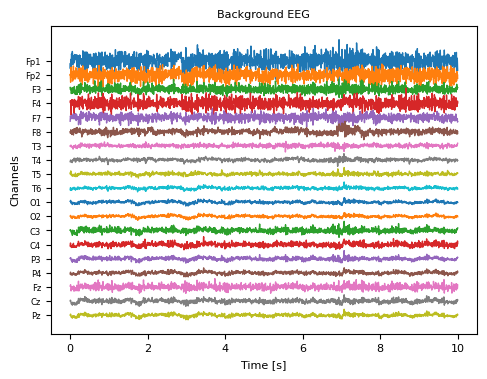

In [12]:
iwasobi = IWasobi()
eeg_sources = iwasobi.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                       PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eog_denoiser = EogDenoiser()
eog_denoiser.fit_fractal_dimensions(eeg_sources)
print(eog_denoiser)

eeg_sources = eog_denoiser.remove_low_dimension_sources([0, 3])

###########################################################
clean_eeg = iwasobi.inverse_transform(eeg_sources)

plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Separated sources using fastica

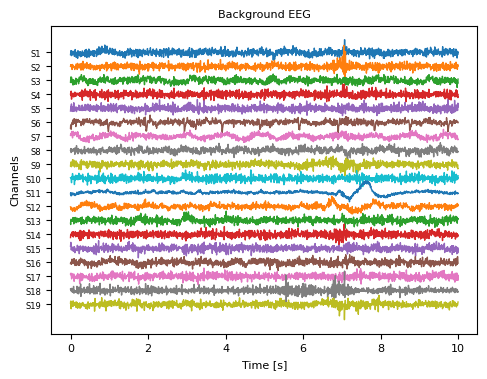

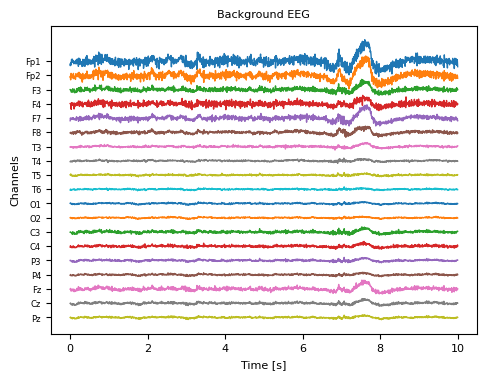

In [13]:
fastica = FastICA()
eeg_sources = fastica.fit_transform(numpy.transpose(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                                       PERIOD[1]*processor.sampling_frequency]))

###########################################################
plot_eeg_windows(numpy.transpose(eeg_sources), current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[1] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
#eeg_sources[16, :] = 0
clean_eeg = fastica.inverse_transform(eeg_sources)
plot_eeg_windows(numpy.transpose(clean_eeg), current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Compute sources using BSS Canonical Correlation Analysis

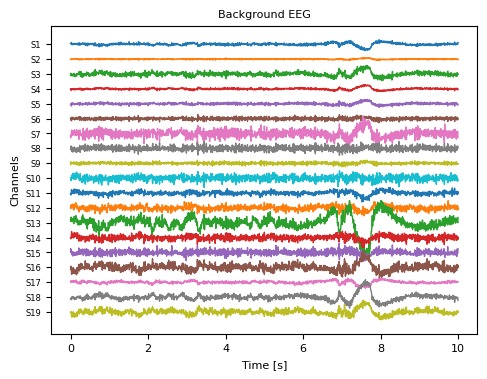

Source = 1, fd = 48.27261284615824
Source = 2, fd = 8.536459124337265
Source = 3, fd = 27.980595779749546
Source = 4, fd = 55.77636362902544
Source = 5, fd = 18.520728515270775
Source = 6, fd = 2.0352563850815675
Source = 7, fd = 12.77351699236032
Source = 8, fd = 1.2049775321825928
Source = 9, fd = 2.464070012382866
Source = 10, fd = 2.5016416157366
Source = 11, fd = 20.2931881162672
Source = 12, fd = 10.942474923453643
Source = 13, fd = 137.55095392407003
Source = 14, fd = 7.59626305400183
Source = 15, fd = 3.58585949098915
Source = 16, fd = 21.108120849158546
Source = 17, fd = 53.12818973126159
Source = 18, fd = 116.73684977439245
Source = 19, fd = 31.668041956279925
Done!
2025-03-10 23:46:33,761 - root - INFO - Number of sources to be removed = 3


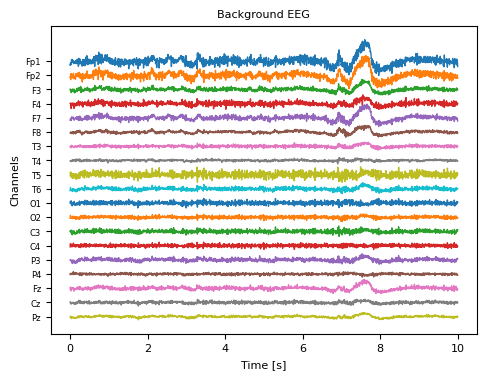

In [14]:
bsscca = CanonicalCorrelation()
eeg_sources = bsscca.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                      PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
emg_denoiser = EmgDenoiser(sampling_frequency=processor.sampling_frequency)
emg_denoiser.fit_psd_ratio(eeg_sources)
print(emg_denoiser)

eeg_sources = emg_denoiser.remove_low_ratio_sources([0, 3])

###########################################################
clean_eeg = bsscca.inverse_transform(eeg_sources)
plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Stationarity tests (KPPS and ADF)

In [15]:
stats_gateway = StatisticalTests()
stats_gateway.check_stationarity(processor._data[15, :4000])

2025-03-10 23:46:44,448 - root - INFO - KPSS test, null hyphotesis was not rejected, p_value = 0.1, significance level = 0.05
2025-03-10 23:46:44,455 - root - INFO - White test, null hyphotesis was rejected, p_value = 7.475105743586324e-22, significance level = 0.05
2025-03-10 23:46:44,456 - root - INFO - The series is trend stationary only (not strict stationarity)


/mnt/c/Users/tobit/Documents/Doctorado/Initiative1_epic1/Project/code/notebooks/../lib/stats.py:99: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  _, p_value, _, _ = stattools.kpss(time_serie, regression="c")


'Trend stationary'